In [2]:
import numpy as np
import matplotlib.pyplot as plt
from useful_functions import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [14]:
#indy_20160407_02_py
data = get_clean_data('indy_20160407_02_py.mat')
data.keys()

dict_keys(['spM', 'evM', 'handM', 'cursorM', 't', 'targetM'])

$t$ is the timestamp corresponding to each sample of the $cursorM$, $handM$, and $targetM$, seconds.


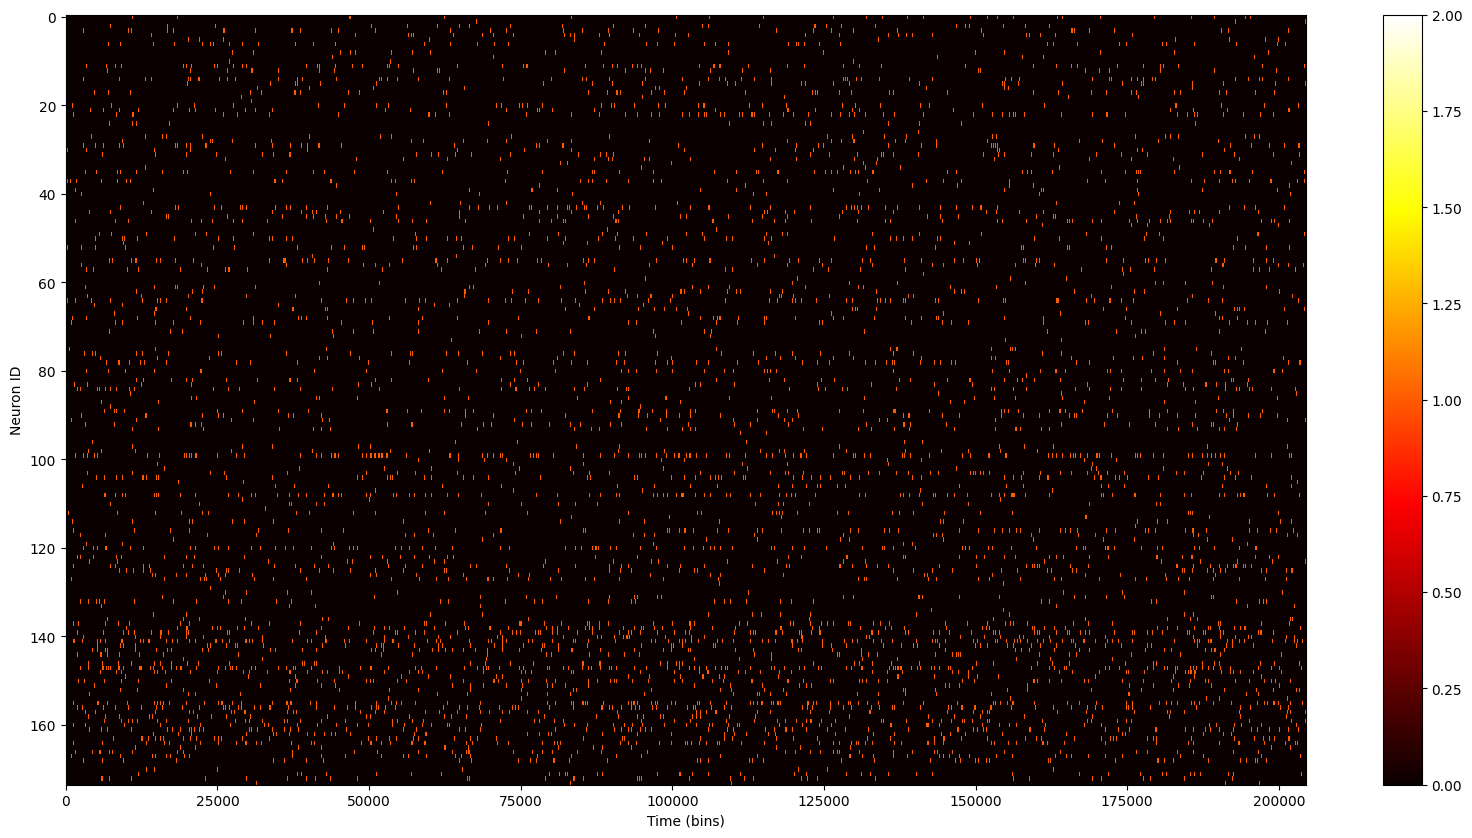

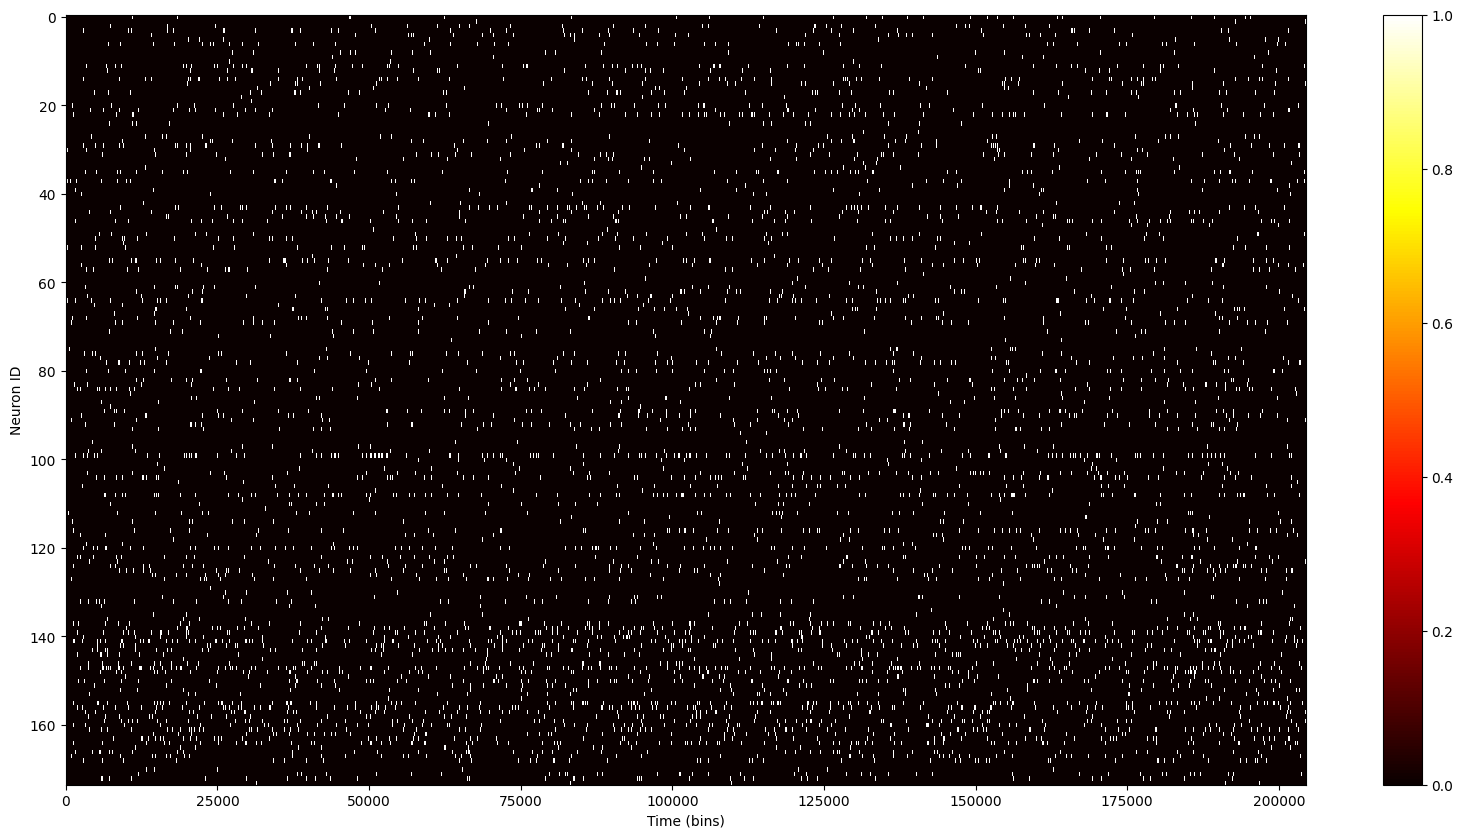

In [15]:
plt.figure(figsize=(20, 10))
plt.imshow(data['spM'], aspect='auto', cmap='hot', interpolation='nearest')
plt.xlabel('Time (bins)')
plt.ylabel('Neuron ID')
plt.colorbar()

plt.figure(figsize=(20, 10))
plt.imshow(data['evM'], aspect='auto', cmap='hot', interpolation='nearest')
plt.xlabel('Time (bins)')
plt.ylabel('Neuron ID')
plt.colorbar()

### Let's try PCA without preprocessing the data (spike binned according to the hand samplig rate)

Explained variance 0.02 0.02 0.02


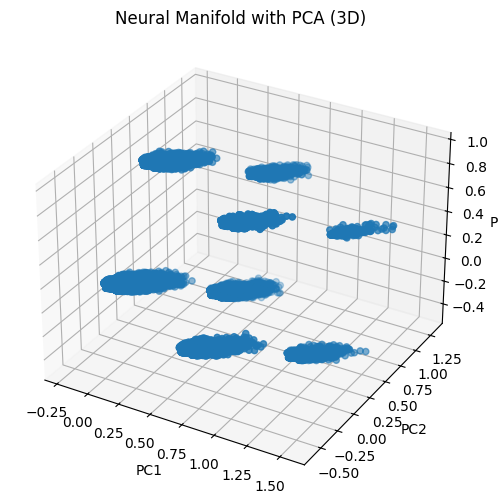

In [16]:
#neural manifold with PCA
pca = PCA(n_components=3)
X = pca.fit_transform(data['evM'].T)

print("Explained variance",*np.round(pca.explained_variance_ratio_, 2))
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Neural Manifold with PCA (3D)')
plt.ion()
plt.show()

### very weird I think the population vector are far to correlated we need to widen the time bins

Text(0.5, 1.0, 'Correlation Matrix')

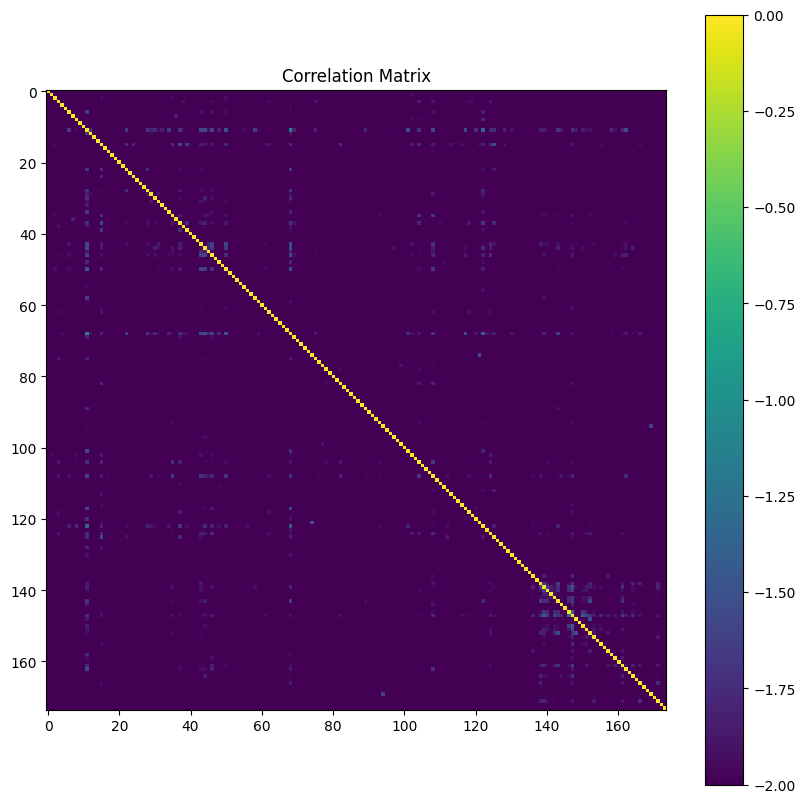

In [17]:
#correlation matrix
corr = np.corrcoef(data['evM'])
logcorr = np.log10(np.abs(corr))
logcorr[corr < 0.01] = -2
plt.figure(figsize=(10, 10))
plt.imshow(logcorr, interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix')


Original shape: (174, 204445)
Resampled shape: (174, 2045)


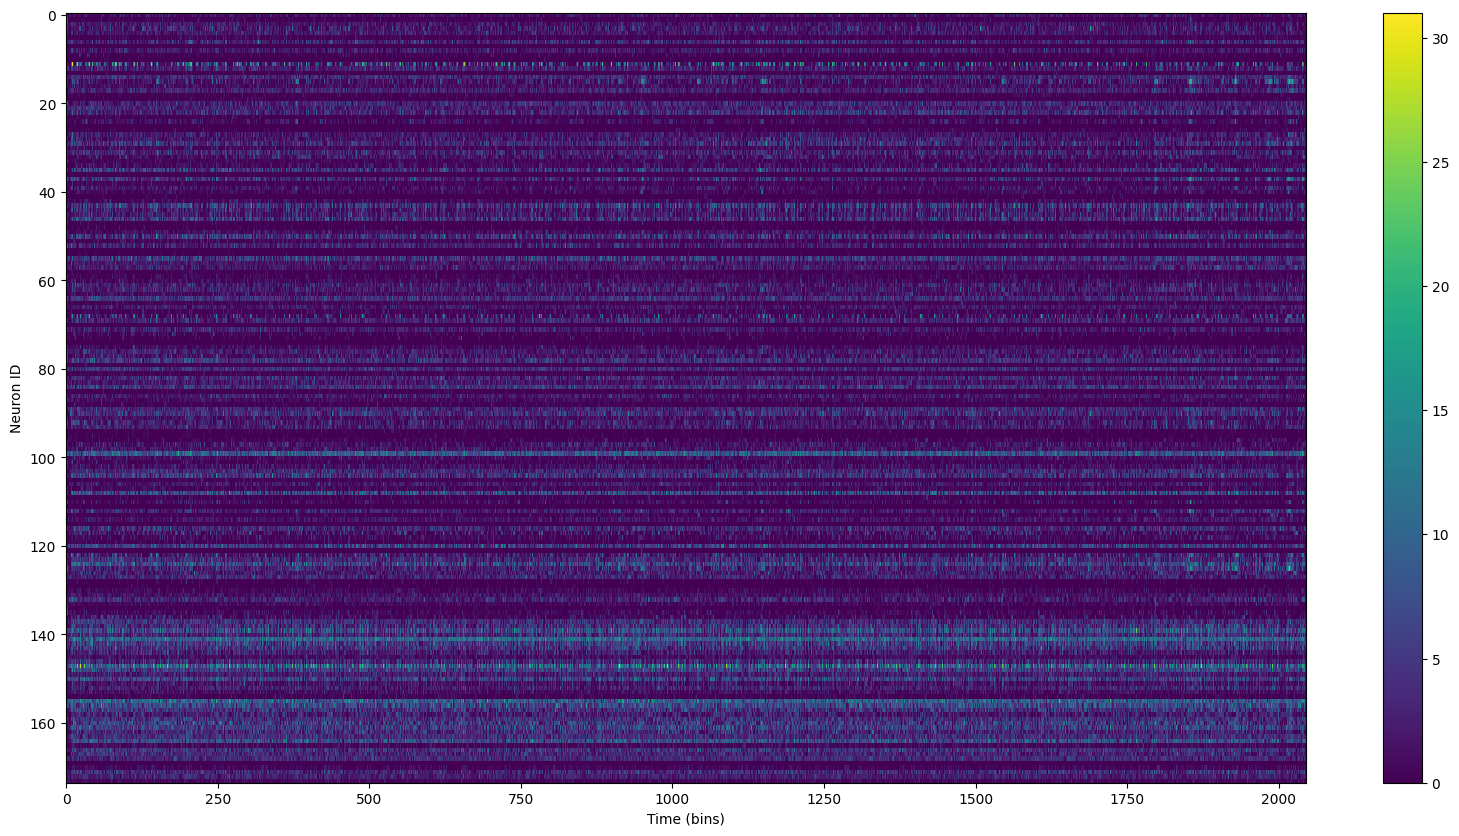

In [18]:
time_bins = data['t']
# Define the new bin size in milliseconds
#choosen according to the time bins
new_bin_size_ms = 400*10**-3  # 400 ms

# Calculate the ratio between the new and old bin sizes
resample_factor = int(new_bin_size_ms / np.mean(np.diff(time_bins)))  # 400 ms / 10 ms = 40

# Resample the matrix by summing the spikes within each new bin
# Use np.add.reduceat to sum spikes within each group of 'resample_factor' bins
# Then reshape the result to match the new number of bins
r_spM = np.add.reduceat(data['spM'], np.arange(0, data['spM'].shape[1], resample_factor), axis=1)

# Verify the shape of the resampled matrix
print("Original shape:", data['spM'].shape)
print("Resampled shape:", r_spM.shape)

plt.figure(figsize=(20, 10))
plt.imshow(r_spM, aspect='auto', interpolation='nearest')
plt.xlabel('Time (bins)')
plt.ylabel('Neuron ID')
plt.colorbar()

### Let's create our labels: base on the monkey's target on the screen:

In [19]:
target_x = data['targetM'][0].flatten()
target_y = data['targetM'][1].flatten()

r_target_x = np.add.reduceat(target_x, np.arange(0, target_x.size, resample_factor),)/resample_factor
r_target_y = np.add.reduceat(target_y, np.arange(0, target_y.size, resample_factor),)/resample_factor

mx = np.mean(r_target_x)
my = np.mean(r_target_y)
r_target_x = r_target_x - mx
r_target_y = r_target_y - my

four_dim_labels = np.zeros_like(r_target_x)
up_down_labels = np.zeros_like(r_target_x)
left_right_labels = np.zeros_like(r_target_x)
for i in range(r_target_x.size):
    four_dim_labels[i] = 0 if r_target_x[i] > 0 and r_target_y[i] > 0 else 1 if r_target_x[i] > 0 and r_target_y[i] < 0 else 2 if r_target_x[i] < 0 and r_target_y[i] < 0 else 3
    #only up and down
    up_down_labels[i] = 0 if r_target_y[i] > 0 else 1
    #only left and right
    left_right_labels[i] = 0 if r_target_x[i] > 0 else 1

np.savetxt('groups.csv', four_dim_labels, delimiter=',')

### Let's create linear SVM classifier to evaluate the prediction

In [20]:
from sklearn.svm import SVC

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(r_spM.T, four_dim_labels, test_size=0.2, random_state=42)

# Train a linear SVM classifier
svm = SVC()
svm.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = svm.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6479217603911981


### PCA

Explained variance 0.22 0.08 0.03


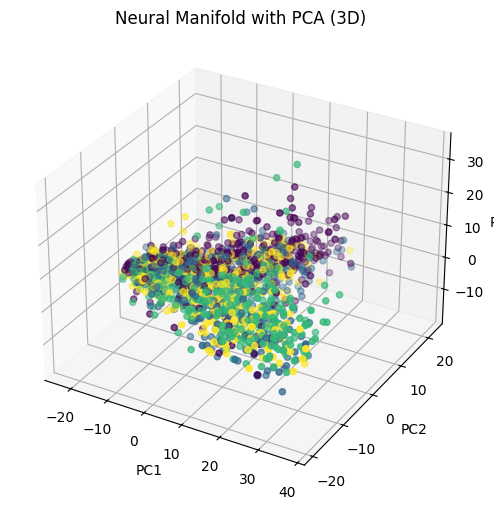

Accuracy: 0.36674816625916873


In [21]:
pca = PCA(n_components=3)
X = pca.fit_transform(r_spM.T)
print("Explained variance",*np.round(pca.explained_variance_ratio_, 2))
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o', c=four_dim_labels, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Neural Manifold with PCA (3D)')
plt.ion()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, four_dim_labels, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

In [22]:
np.savetxt('manifold.csv', X, delimiter=',')

### Autoencoder

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0063
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 13/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 14/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 15/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoc

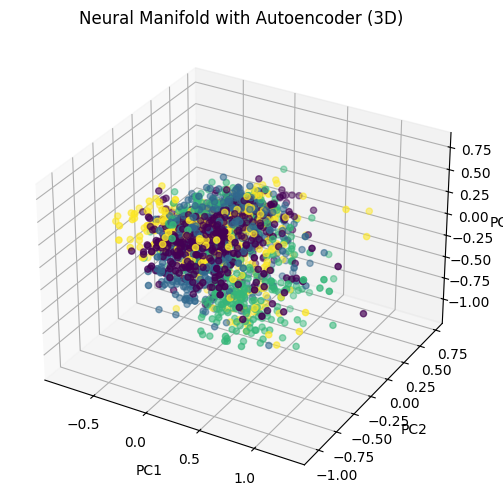

Accuracy: 0.5330073349633252


In [23]:
#autoencoder
input_size = 174

# Generate random data for demonstration
xx = r_spM.T/np.max(r_spM)

dimension= 1000
latent_dim = 3


input_data = Input(shape=(input_size,))
# Encoder
encoded = Dense(dimension, activation='relu')(input_data)
encoded = Dense(latent_dim)(encoded)  # Latent space representation

# Define the encoder model
encoder = Model(input_data, encoded)

# Decoders
decoded = Dense(dimension, activation='relu')(encoded)
decoded = Dense(input_size)(decoded)

# Combine encoder and decoder to create autoencoder model
autoencoder = Model(input_data, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

#fit the model
autoencoder.fit(xx, xx, epochs=100, batch_size=32, verbose=1)

# Viusalize the latent space
X = encoder.predict(xx, verbose=0)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o', c=four_dim_labels, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Neural Manifold with Autoencoder (3D)')
plt.ion()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, four_dim_labels, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

In [24]:
np.savetxt('manifold.csv', X, delimiter=',')

### t-distributed stochastic neighbor embedding

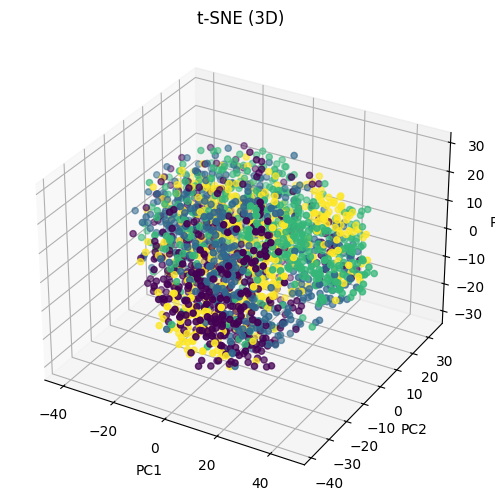

Accuracy: 0.5281173594132029


In [25]:
from sklearn.manifold import TSNE
X = TSNE(n_components=3).fit_transform(r_spM.T)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o', c=four_dim_labels, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('t-SNE (3D)')
plt.ion()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, four_dim_labels, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

In [26]:
np.savetxt('manifold.csv', X, delimiter=',')

### ISOMAP

Accuracy: 0.4229828850855746


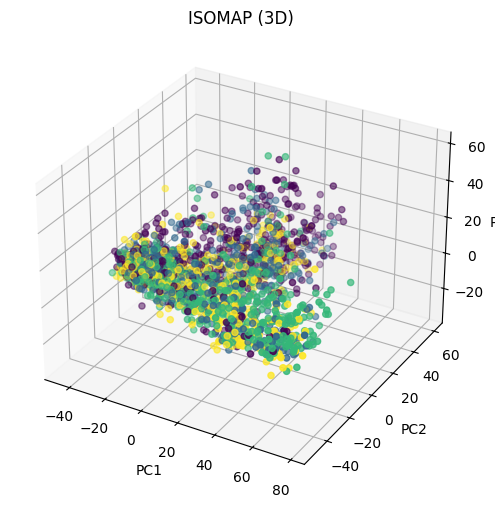

In [27]:
from sklearn.manifold import Isomap
isomap = Isomap(n_components=3, n_jobs=-1, n_neighbors=50)
X = isomap.fit_transform(r_spM.T)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o', c=four_dim_labels, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('ISOMAP (3D)')
plt.ion()

X_train, X_test, y_train, y_test = train_test_split(X, four_dim_labels, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

In [28]:
np.savetxt('manifold.csv', X, delimiter=',')

### Locally linear embedding

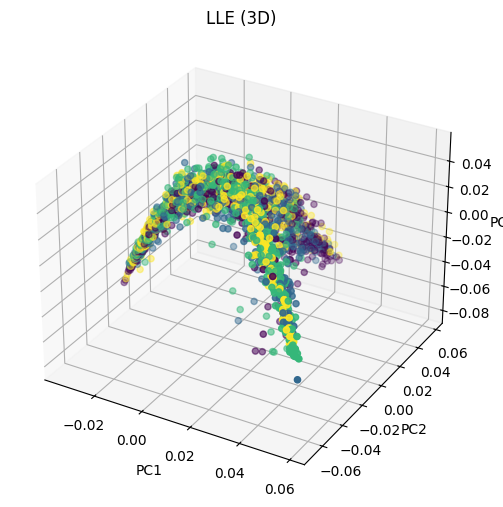

Accuracy: 0.36674816625916873


In [29]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=3, n_neighbors=30, n_jobs=-1)
X = lle.fit_transform(r_spM.T)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o', c=four_dim_labels, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('LLE (3D)')
plt.ion()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, four_dim_labels, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

### Factor Analysis

Accuracy: 0.39853300733496333


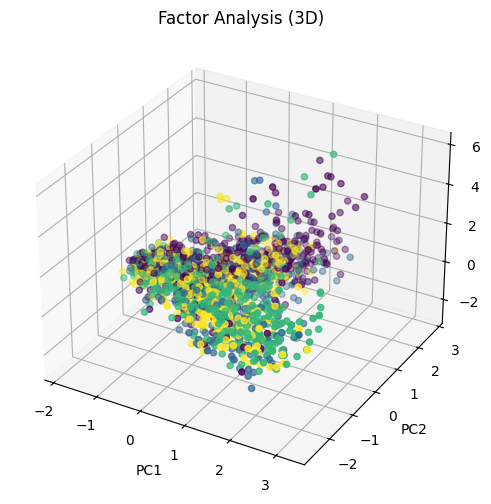

In [30]:
from sklearn.decomposition import FactorAnalysis
fa = FactorAnalysis(n_components=3)
X = fa.fit_transform(r_spM.T)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o', c=four_dim_labels, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Factor Analysis (3D)')
plt.ion()   

X_train, X_test, y_train, y_test = train_test_split(X, four_dim_labels, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

In [31]:
np.savetxt('manifold.csv', X, delimiter=',')

###  Fisher discriminant analysis


Accuracy: 0.7041564792176039


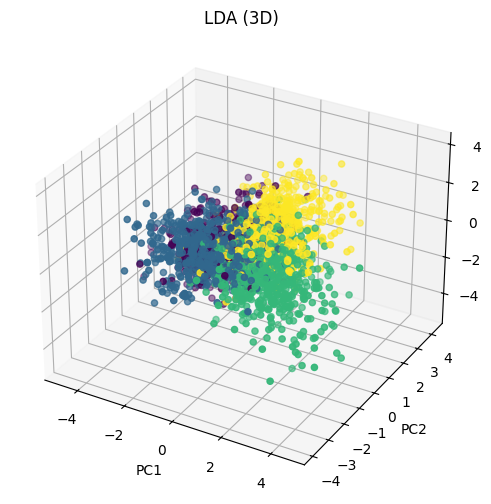

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=3)
X = lda.fit_transform(r_spM.T, four_dim_labels)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o', c=four_dim_labels, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('LDA (3D)')
plt.ion()

X_train, X_test, y_train, y_test = train_test_split(X, four_dim_labels, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

In [33]:
np.savetxt('manifold.csv', X, delimiter=',')

### Laplacian eigenmaps

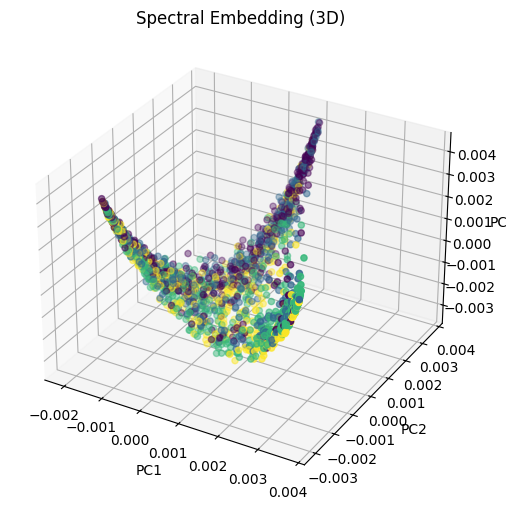

Accuracy: 0.3643031784841076


In [34]:
from sklearn.manifold import SpectralEmbedding
se = SpectralEmbedding(n_components=3)
X = se.fit_transform(r_spM.T)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o', c=four_dim_labels, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Spectral Embedding (3D)')
plt.ion()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, four_dim_labels, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

In [35]:
np.savetxt('manifold.csv', X, delimiter=',')

### Expend the state space size

In [36]:
from itertools import combinations_with_replacement
def expand_state_space(data, order):
    """
    Expand the state space by adding higher-order interactions.

    Parameters:
    - data: np.ndarray of shape (n_samples, n_features)
    - order: int, the order of interactions to include

    Returns:
    - expanded_data: np.ndarray of shape (n_samples, new_features)
    """
    n_features, n_samples = data.shape
    expanded_data = [data]

    # Generate combinations of features up to the specified order
    for o in range(2, order + 1):
        for combo in combinations_with_replacement(range(n_features), o):
            new_feature = np.prod(data[combo,:], axis=0, keepdims=True)
            expanded_data.append(new_feature)
    
    return np.vstack(expanded_data)

In [37]:
m = np.arange(12).reshape(3, 4)
print(m)
print(expand_state_space(m, 2))

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[  0   1   2   3]
 [  4   5   6   7]
 [  8   9  10  11]
 [  0   1   4   9]
 [  0   5  12  21]
 [  0   9  20  33]
 [ 16  25  36  49]
 [ 32  45  60  77]
 [ 64  81 100 121]]


### Finding the best higher order with FDA is too hard for my poor computer so let's try with $O(2)$

In [38]:
# best_order = 0
# best_accuracy = 0

# orders = np.arange(1, 6)
# for order in orders:
#     expanded_spM = expand_state_space(r_spM, order)
#     lda = LinearDiscriminantAnalysis(n_components=3)
#     X = lda.fit_transform(expanded_spM.T, four_dim_labels)

#     X_train, X_test, y_train, y_test = train_test_split(X, four_dim_labels, test_size=0.2, random_state=42)
#     svm = SVC()
#     svm.fit(X_train, y_train)
#     y_pred = svm.predict(X_test)
#     accuracy = np.mean(y_pred == y_test)
#     print("Order:", order, "| Accuracy:", accuracy)
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_order = order

### Order 2 expension

In [39]:
order = 2
expanded_spM = expand_state_space(r_spM, order)
lda = LinearDiscriminantAnalysis(n_components=3)
X = lda.fit_transform(expanded_spM.T, four_dim_labels)

plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='o', c=four_dim_labels, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Expanded State Space (3D)')
plt.ion()

X_train, X_test, y_train, y_test = train_test_split(X, four_dim_labels, test_size=0.2, random_state=42)
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)


Accuracy: 0.8899755501222494


<Figure size 1000x600 with 0 Axes>

In [40]:
np.savetxt('manifold.csv', X, delimiter=',')

### Order 3 expension requires to much memory

### why make higher order expension

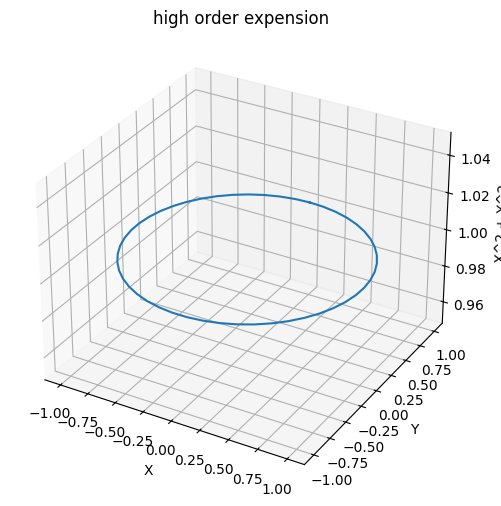

In [41]:
t = np.linspace(0,2*np.pi)
x = np.sin(t)
y = np.cos(t)
z = x**2 + y**2

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('X^2 + Y^2')
ax.set_title('high order expension')
plt.ion()

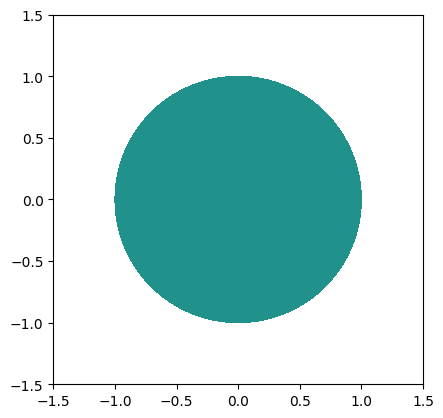

In [42]:
# Disk parameters
center = (0, 0)  # Center of the disk (x, y)
radius = 1  # Radius of the disk

# Create a meshgrid
x = np.linspace(-1.5, 1.5, 400)
y = np.linspace(-1.5, 1.5, 400)
X, Y = np.meshgrid(x, y)

# Calculate the distance from the center
Z = (X - center[0])**2 + (Y - center[1])**2

# Plot the disk
fig, ax = plt.subplots()
ax.contourf(X, Y, Z, levels=[0, radius**2])  # Fill the disk with color
ax.set_aspect('equal')  # Ensure the aspect ratio is equal
ax.set_xlim(-1.5, 1.5)  # Set limits to visualize the disk clearly
ax.set_ylim(-1.5, 1.5)
plt.show()


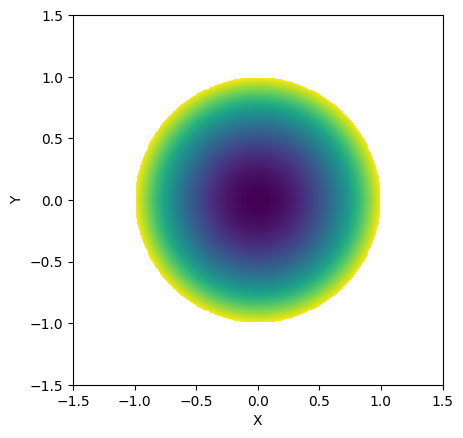

In [45]:
# Disk parameters
center = (0, 0)  # Center of the disk (x, y)
radius = 1  # Radius of the disk

# Create a meshgrid
x = np.linspace(-1.5, 1.5, 400)
y = np.linspace(-1.5, 1.5, 400)
X, Y = np.meshgrid(x, y)

# Calculate the distance from the center
Z = (X - center[0])**2 + (Y - center[1])**2

# Mask the outside of the disk
Z = np.ma.masked_where(Z > radius, Z)

# Plot the disk with gradation
fig, ax = plt.subplots()
c = ax.imshow(Z, extent=(-1.5, 1.5, -1.5, 1.5), origin='lower', cmap='viridis')  # Use a colormap
#fig.colorbar(c, ax=ax)  # Add a colorbar
ax.set_aspect('equal')  # Ensure the aspect ratio is equal
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()


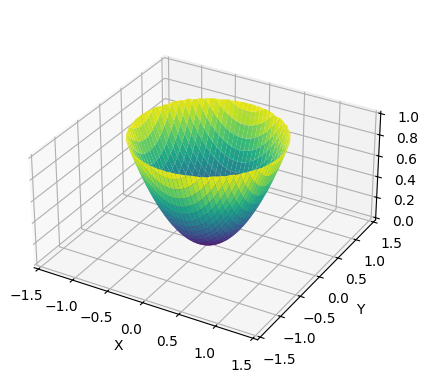

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Disk parameters
center = (0, 0)  # Center of the disk (x, y)
radius = 1  # Radius of the disk

# Create a meshgrid
x = np.linspace(-1.5, 1.5, 400)
y = np.linspace(-1.5, 1.5, 400)
X, Y = np.meshgrid(x, y)

# Calculate the distance from the center
Z = (X - center[0])**2 + (Y - center[1])**2

# Mask the outside of the disk
Z = np.ma.masked_where(Z > radius, Z)

# Plot the disk in 3D with gradation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Add a colorbar
#fig.colorbar(surf, ax=ax)

# Set aspect ratio to be equal
ax.set_box_aspect([1, 1, 0.5])  # Aspect ratio is 1:1:0.5

#ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlabel('X')

# Set limits to visualize the disk clearly
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(0, radius)

plt.show()
